In [20]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping

from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, GRU, SimpleRNN
import glob
from datetime import datetime
from keras.layers import Dropout
#import pyemd
%matplotlib inline


In [3]:
import glob

all_data = pd.DataFrame()
path = 'C:\\Users\\kuruparans\\Documents\\Prof.Suganthan\\Canada_ON&QC_winddata_2017\\ON_Jan_*.xlsx'
for f in glob.glob(path):
    df = pd.read_excel(f, sheet_name=None, ignore_index=True, usecols=['windspd','month','day','hour'])
    cdf = pd.concat(df.values())
    all_data = all_data.append(cdf,ignore_index=True)
print(all_data)
dataframe=all_data

      day  hour  month  windspd
0     NaN   NaN    NaN      NaN
1     NaN   NaN    NaN      NaN
2     NaN   NaN    NaN      NaN
3     1.0   0.0    1.0     16.0
4     1.0   1.0    1.0     14.0
..    ...   ...    ...      ...
742  31.0  19.0    1.0     12.0
743  31.0  20.0    1.0      9.0
744  31.0  21.0    1.0     13.0
745  31.0  22.0    1.0     11.0
746  31.0  23.0    1.0     11.0

[747 rows x 4 columns]


In [4]:
month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [5]:
dataframe

,day,hour,month,windspd
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,1.0,0.0,1.0,16.0
4,1.0,1.0,1.0,14.0
5,1.0,2.0,1.0,14.0
6,1.0,3.0,1.0,28.0
7,1.0,4.0,1.0,25.0
8,1.0,5.0,1.0,24.0
9,1.0,6.0,1.0,27.0


In [6]:
dataframe['date_time']=(dataframe['month']-1)*30*24+(dataframe['day']-1) *24 + dataframe['hour']
dataframe=dataframe[['date_time','windspd'] ]
dataframe=dataframe.dropna()

In [7]:
dataframe

,date_time,windspd
3,0.0,16.0
4,1.0,14.0
5,2.0,14.0
6,3.0,28.0
7,4.0,25.0
8,5.0,24.0
9,6.0,27.0
10,7.0,22.0
11,8.0,21.0
12,9.0,15.0


In [8]:
import PyEMD

In [9]:
from PyEMD import EMD
n = dataframe['windspd'].as_matrix()

s = np.random.random(len(dataframe['windspd']))

emd = EMD()
IMFs = emd(n)

C:\Users\kuruparans\AppData\Local\conda\conda\envs\wind\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [10]:
IMFs

array([[-0.66790754,  2.71212809, -2.74378505, ...,  1.35008671,
        -1.35611926, -0.85022025],
       [-1.86273396, -7.42049748, -2.54181281, ...,  0.92640973,
         2.33833233,  1.92664837],
       [-1.08244378, -1.42851832, -1.13616156, ..., -1.74263486,
        -2.05089199, -1.61667031],
       ...,
       [-7.34189206, -7.37508634, -7.41935485, ...,  3.13588011,
         3.13857642,  3.1391957 ],
       [ 3.57245077,  3.57770624,  3.58303008, ...,  1.01738336,
         1.0053706 ,  0.99385339],
       [13.84318414, 13.8426982 , 13.84218785, ..., 11.46997337,
        11.47039354, 11.47084063]])

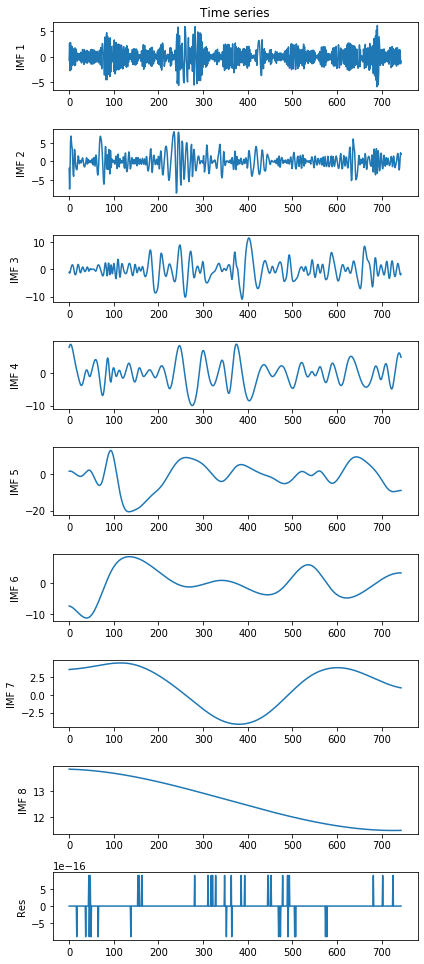

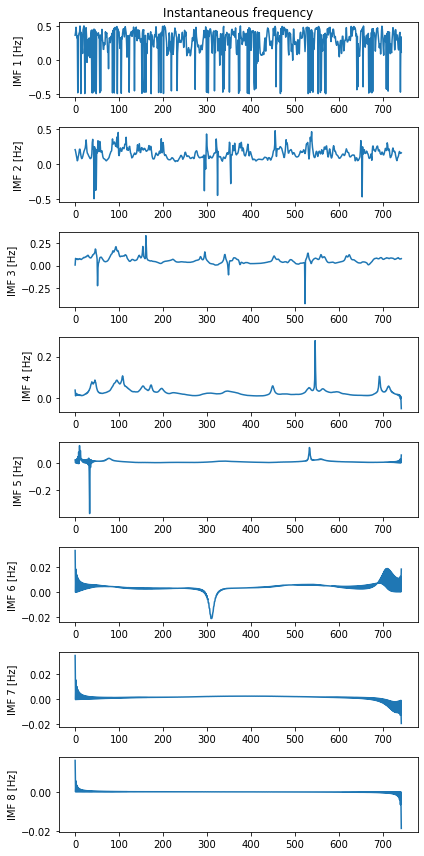

In [11]:
import numpy as np
from PyEMD import EMD, Visualisation

t = np.arange(0, len(dataframe['windspd']), 1)
S = np.sin(13*t + 0.2*t**1.4) - np.cos(3*t)

# Extract imfs and residue
# In case of EMD
emd = EMD()
emd.emd(n)
imfs, res = emd.get_imfs_and_residue()

# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [12]:
dataframe['windspd']=imfs[5]

In [13]:
''' Dividing data in test and train sets '''
dataset = dataframe.values
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

558 186


In [14]:
''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [15]:
''' Creating time frames with look backs '''
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

534
162


In [16]:
trainY

array([ -9.97574461, -10.10284855, -10.22558854, -10.34330056,
       -10.45532382, -10.56101021, -10.65971383, -10.75078856,
       -10.83358828, -10.90746685, -10.97177815, -11.02587605,
       -11.06911443, -11.10084715, -11.12042809, -11.12721056,
       -11.12054442, -11.09977448, -11.06424444, -11.01329799,
       -10.94627881, -10.86253059, -10.76146994, -10.64294501,
       -10.5074364 , -10.35556458, -10.18795005, -10.00521329,
        -9.80797477,  -9.59685499,  -9.37247442,  -9.13545355,
        -8.88641285,  -8.62597281,  -8.35475392,  -8.07337665,
        -7.78246149,  -7.48262893,  -7.17449943,  -6.85869349,
        -6.53583101,  -6.20652962,  -5.87140637,  -5.53107828,
        -5.18614953,  -4.83717266,  -4.48468734,  -4.12923321,
        -3.77134995,  -3.41157721,  -3.05045464,  -2.68852192,
        -2.32631868,  -1.96438461,  -1.60325934,  -1.24348255,
        -0.8855939 ,  -0.53013303,  -0.17763961,   0.17134671,
         0.51628625,   0.85663937,   1.19186641,   1.52

In [50]:
trainX

array([[ -7.34189206,  -7.37508634,  -7.41935485, ...,  -9.57488932,
         -9.71110098,  -9.84494075],
       [ -7.37508634,  -7.41935485,  -7.4744687 , ...,  -9.71110098,
         -9.84494075,  -9.97574461],
       [ -7.41935485,  -7.4744687 ,  -7.53982702, ...,  -9.84494075,
         -9.97574461, -10.10284855],
       ...,
       [  5.62700989,   5.65727923,   5.67974492, ...,   4.45731237,
          4.31212767,   4.16098477],
       [  5.65727923,   5.67974492,   5.69422835, ...,   4.31212767,
          4.16098477,   4.00424949],
       [  5.67974492,   5.69422835,   5.7005509 , ...,   4.16098477,
          4.00424949,   3.84228764]])

In [17]:
''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
trainX.shape



(534, 1, 24)

W0730 05:17:46.112569 12660 deprecation_wrapper.py:119] From C:\Users\kuruparans\AppData\Local\conda\conda\envs\wind\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 05:17:46.122674 12660 deprecation_wrapper.py:119] From C:\Users\kuruparans\AppData\Local\conda\conda\envs\wind\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 05:17:46.132698 12660 deprecation_wrapper.py:119] From C:\Users\kuruparans\AppData\Local\conda\conda\envs\wind\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 05:17:46.368584 12660 deprecation_wrapper.py:119] From C:\Users\kuruparans\AppData\Local\conda\conda\envs\wind\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 1s 1ms/step - loss: 3.5129 - val_loss: 2.4191
Epoch 2/300
534/534 [==============================] - 0s 59us/step - loss: 3.1786 - val_loss: 2.1185
Epoch 3/300
534/534 [==============================] - 0s 40us/step - loss: 2.8517 - val_loss: 1.8820
Epoch 4/300
534/534 [==============================] - 0s 42us/step - loss: 2.6403 - val_loss: 1.7168
Epoch 5/300
534/534 [==============================] - 0s 37us/step - loss: 2.4720 - val_loss: 1.5843
Epoch 6/300
534/534 [==============================] - 0s 48us/step - loss: 2.3245 - val_loss: 1.4721
Epoch 7/300
534/534 [==============================] - 0s 52us/step - loss: 2.2000 - val_loss: 1.3726
Epoch 8/300
534/534 [==============================] - 0s 51us/step - loss: 2.0955 - val_loss: 1.2785
Epoch 9/300
534/534 [==============================] - 0s 52us/step - loss: 1.9974 - val_loss: 1.1907
Epoch 10/300
534/534 [===============

Epoch 80/300
534/534 [==============================] - 0s 60us/step - loss: 0.6975 - val_loss: 0.3759
Epoch 81/300
534/534 [==============================] - 0s 63us/step - loss: 0.7567 - val_loss: 0.3487
Epoch 82/300
534/534 [==============================] - 0s 57us/step - loss: 0.7572 - val_loss: 0.3139
Epoch 83/300
534/534 [==============================] - 0s 70us/step - loss: 0.7296 - val_loss: 0.2933
Epoch 84/300
534/534 [==============================] - 0s 62us/step - loss: 0.7323 - val_loss: 0.3368
Epoch 85/300
534/534 [==============================] - 0s 61us/step - loss: 0.7089 - val_loss: 0.2531
Epoch 86/300
534/534 [==============================] - 0s 68us/step - loss: 0.7677 - val_loss: 0.3230
Epoch 87/300
534/534 [==============================] - 0s 68us/step - loss: 0.7299 - val_loss: 0.3428
Epoch 88/300
534/534 [==============================] - 0s 104us/step - loss: 0.7167 - val_loss: 0.2639
Epoch 89/300
534/534 [==============================] - 0s 44us/step - l

Epoch 159/300
534/534 [==============================] - 0s 52us/step - loss: 0.4739 - val_loss: 0.1399
Epoch 160/300
534/534 [==============================] - 0s 52us/step - loss: 0.5396 - val_loss: 0.3093
Epoch 161/300
534/534 [==============================] - 0s 29us/step - loss: 0.4916 - val_loss: 0.1339
Epoch 162/300
534/534 [==============================] - 0s 40us/step - loss: 0.5431 - val_loss: 0.1895
Epoch 163/300
534/534 [==============================] - 0s 66us/step - loss: 0.5451 - val_loss: 0.1251
Epoch 164/300
534/534 [==============================] - 0s 35us/step - loss: 0.5456 - val_loss: 0.2058
Epoch 165/300
534/534 [==============================] - 0s 87us/step - loss: 0.4887 - val_loss: 0.3179
Epoch 166/300
534/534 [==============================] - 0s 59us/step - loss: 0.5959 - val_loss: 0.2413
Epoch 167/300
534/534 [==============================] - 0s 37us/step - loss: 0.4659 - val_loss: 0.1423
Epoch 168/300
534/534 [==============================] - 0s 59us

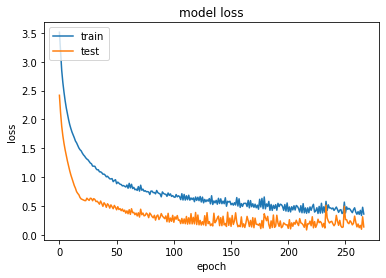

In [53]:
model = Sequential()
model.add(LSTM(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Root mean squared error Train: 0.738
Root mean squared error Test: 0.157


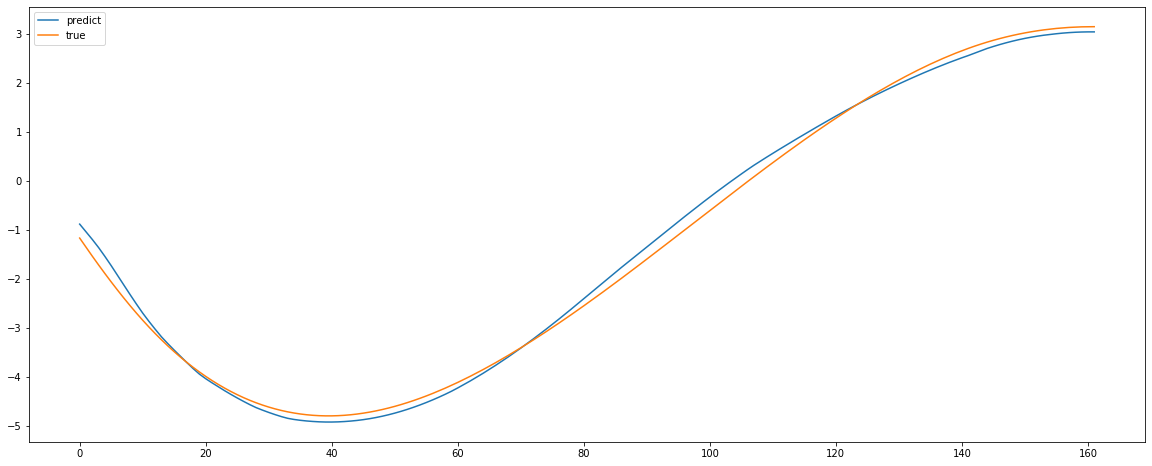

Variance : 0.997
Mean absolute error Train: 0.345
Mean absolute error Test: 0.135


In [54]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [307]:
#changing loss funtion to RMSE 

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 1s 2ms/step - loss: 3.5216 - acc: 0.0000e+00 - val_loss: 2.6681 - val_acc: 0.0000e+00
Epoch 2/300
534/534 [==============================] - 0s 39us/step - loss: 3.2788 - acc: 0.0000e+00 - val_loss: 2.5160 - val_acc: 0.0000e+00
Epoch 3/300
534/534 [==============================] - 0s 43us/step - loss: 3.1143 - acc: 0.0000e+00 - val_loss: 2.3929 - val_acc: 0.0000e+00
Epoch 4/300
534/534 [==============================] - 0s 37us/step - loss: 2.9893 - acc: 0.0000e+00 - val_loss: 2.2798 - val_acc: 0.0000e+00
Epoch 5/300
534/534 [==============================] - 0s 38us/step - loss: 2.8818 - acc: 0.0000e+00 - val_loss: 2.1750 - val_acc: 0.0000e+00
Epoch 6/300
534/534 [==============================] - 0s 45us/step - loss: 2.7883 - acc: 0.0000e+00 - val_loss: 2.0809 - val_acc: 0.0000e+00
Epoch 7/300
534/534 [==============================] - 0s 44us/step - loss: 2.7031 - acc: 0.0000e+00 - 

534/534 [==============================] - 0s 44us/step - loss: 1.1164 - acc: 0.0000e+00 - val_loss: 0.9205 - val_acc: 0.0000e+00
Epoch 59/300
534/534 [==============================] - 0s 45us/step - loss: 1.1077 - acc: 0.0000e+00 - val_loss: 0.9082 - val_acc: 0.0000e+00
Epoch 60/300
534/534 [==============================] - 0s 52us/step - loss: 1.1054 - acc: 0.0000e+00 - val_loss: 0.8944 - val_acc: 0.0000e+00
Epoch 61/300
534/534 [==============================] - 0s 45us/step - loss: 1.0904 - acc: 0.0000e+00 - val_loss: 0.8853 - val_acc: 0.0000e+00
Epoch 62/300
534/534 [==============================] - 0s 45us/step - loss: 1.0843 - acc: 0.0000e+00 - val_loss: 0.8734 - val_acc: 0.0000e+00
Epoch 63/300
534/534 [==============================] - 0s 52us/step - loss: 1.0816 - acc: 0.0000e+00 - val_loss: 0.8598 - val_acc: 0.0000e+00
Epoch 64/300
534/534 [==============================] - 0s 45us/step - loss: 1.0653 - acc: 0.0000e+00 - val_loss: 0.8514 - val_acc: 0.0000e+00
Epoch 65/300

Epoch 172/300
534/534 [==============================] - 0s 70us/step - loss: 0.6846 - acc: 0.0000e+00 - val_loss: 0.4084 - val_acc: 0.0000e+00
Epoch 173/300
534/534 [==============================] - 0s 33us/step - loss: 0.6956 - acc: 0.0000e+00 - val_loss: 0.4472 - val_acc: 0.0000e+00
Epoch 174/300
534/534 [==============================] - 0s 49us/step - loss: 0.6818 - acc: 0.0000e+00 - val_loss: 0.4355 - val_acc: 0.0000e+00
Epoch 175/300
534/534 [==============================] - 0s 45us/step - loss: 0.6760 - acc: 0.0000e+00 - val_loss: 0.4328 - val_acc: 0.0000e+00
Epoch 176/300
534/534 [==============================] - 0s 53us/step - loss: 0.6683 - acc: 0.0000e+00 - val_loss: 0.4425 - val_acc: 0.0000e+00
Epoch 177/300
534/534 [==============================] - 0s 29us/step - loss: 0.6678 - acc: 0.0000e+00 - val_loss: 0.4292 - val_acc: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm

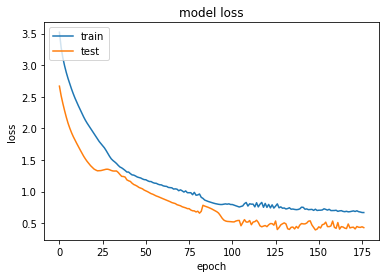

Root mean squared error Train: 1.743
Root mean squared error Test: 0.465


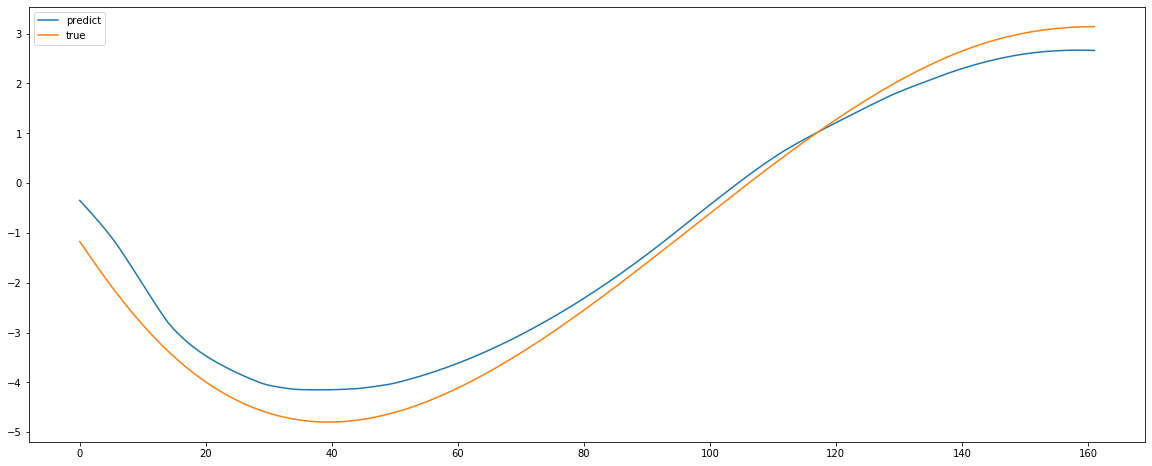

Variance : 0.972
Mean absolute error Train: 0.833
Mean absolute error Test: 0.405


In [55]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(LSTM(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [56]:
#GRU Unit

Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 1s 1ms/step - loss: 2.7960 - val_loss: 1.7218
Epoch 2/300
534/534 [==============================] - 0s 44us/step - loss: 2.5251 - val_loss: 1.5490
Epoch 3/300
534/534 [==============================] - 0s 32us/step - loss: 2.3232 - val_loss: 1.4308
Epoch 4/300
534/534 [==============================] - 0s 45us/step - loss: 2.2028 - val_loss: 1.3519
Epoch 5/300
534/534 [==============================] - 0s 45us/step - loss: 2.1197 - val_loss: 1.2956
Epoch 6/300
534/534 [==============================] - 0s 45us/step - loss: 2.0454 - val_loss: 1.2458
Epoch 7/300
534/534 [==============================] - 0s 50us/step - loss: 1.9760 - val_loss: 1.1982
Epoch 8/300
534/534 [==============================] - 0s 45us/step - loss: 1.9092 - val_loss: 1.1513
Epoch 9/300
534/534 [==============================] - 0s 50us/step - loss: 1.8433 - val_loss: 1.1058
Epoch 10/300
534/534 [===============

Epoch 80/300
534/534 [==============================] - 0s 37us/step - loss: 0.9088 - val_loss: 0.5029
Epoch 81/300
534/534 [==============================] - 0s 37us/step - loss: 0.8019 - val_loss: 0.5358
Epoch 82/300
534/534 [==============================] - 0s 37us/step - loss: 0.8025 - val_loss: 0.5007
Epoch 83/300
534/534 [==============================] - 0s 47us/step - loss: 0.8568 - val_loss: 0.5300
Epoch 84/300
534/534 [==============================] - 0s 29us/step - loss: 0.7791 - val_loss: 0.5315
Epoch 85/300
534/534 [==============================] - 0s 45us/step - loss: 0.8116 - val_loss: 0.5242
Epoch 86/300
534/534 [==============================] - 0s 70us/step - loss: 0.8454 - val_loss: 0.5382
Epoch 87/300
534/534 [==============================] - 0s 26us/step - loss: 0.7592 - val_loss: 0.4746
Epoch 88/300
534/534 [==============================] - 0s 58us/step - loss: 0.8917 - val_loss: 0.5750
Epoch 89/300
534/534 [==============================] - 0s 38us/step - lo

Epoch 159/300
534/534 [==============================] - 0s 52us/step - loss: 0.7559 - val_loss: 0.6604
Epoch 160/300
534/534 [==============================] - 0s 45us/step - loss: 0.7234 - val_loss: 0.6157
Epoch 161/300
534/534 [==============================] - 0s 52us/step - loss: 0.6878 - val_loss: 0.4902
Epoch 162/300
534/534 [==============================] - 0s 45us/step - loss: 0.5726 - val_loss: 0.4346
Epoch 163/300
534/534 [==============================] - 0s 45us/step - loss: 0.5802 - val_loss: 0.3645
Epoch 164/300
534/534 [==============================] - 0s 45us/step - loss: 0.6987 - val_loss: 0.4970
Epoch 165/300
534/534 [==============================] - 0s 52us/step - loss: 0.5473 - val_loss: 0.3766
Epoch 166/300
534/534 [==============================] - 0s 45us/step - loss: 0.7258 - val_loss: 0.5458
Epoch 167/300
534/534 [==============================] - 0s 52us/step - loss: 0.5238 - val_loss: 0.3936
Epoch 168/300
534/534 [==============================] - 0s 45us

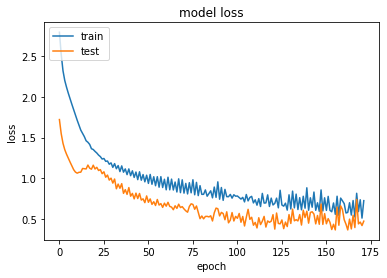

In [57]:
model = Sequential()
model.add(GRU(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Root mean squared error Train: 1.210
Root mean squared error Test: 0.601


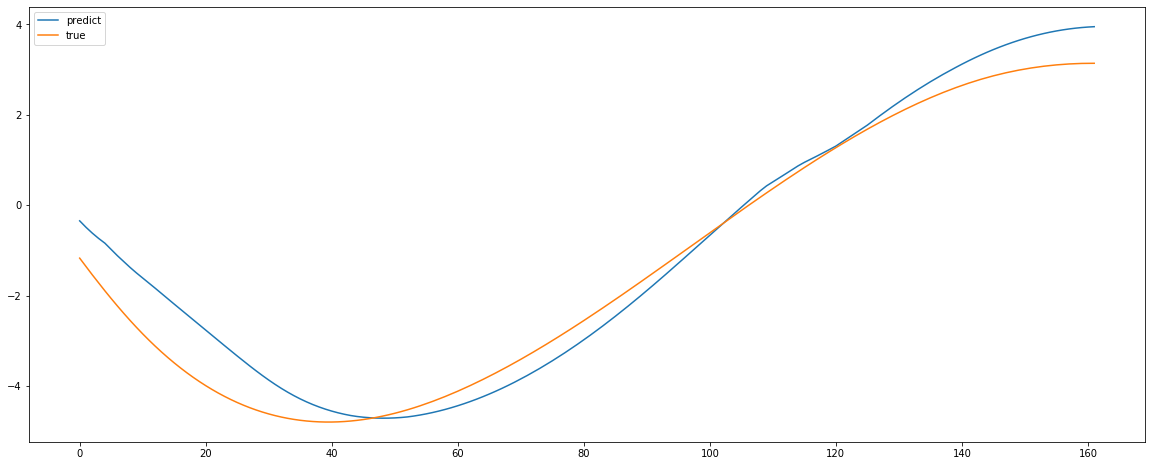

Variance : 0.953
Mean absolute error Train: 0.570
Mean absolute error Test: 0.472


In [58]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))


Train on 534 samples, validate on 162 samples
Epoch 1/300
534/534 [==============================] - 1s 2ms/step - loss: 3.9055 - acc: 0.0000e+00 - val_loss: 2.6772 - val_acc: 0.0000e+00
Epoch 2/300
534/534 [==============================] - 0s 58us/step - loss: 3.2395 - acc: 0.0000e+00 - val_loss: 2.2586 - val_acc: 0.0000e+00
Epoch 3/300
534/534 [==============================] - 0s 42us/step - loss: 2.9547 - acc: 0.0000e+00 - val_loss: 2.0229 - val_acc: 0.0000e+00
Epoch 4/300
534/534 [==============================] - 0s 35us/step - loss: 2.7907 - acc: 0.0000e+00 - val_loss: 1.8403 - val_acc: 0.0000e+00
Epoch 5/300
534/534 [==============================] - 0s 37us/step - loss: 2.6557 - acc: 0.0000e+00 - val_loss: 1.6660 - val_acc: 0.0000e+00
Epoch 6/300
534/534 [==============================] - 0s 47us/step - loss: 2.5042 - acc: 0.0000e+00 - val_loss: 1.5229 - val_acc: 0.0000e+00
Epoch 7/300
534/534 [==============================] - 0s 45us/step - loss: 2.3616 - acc: 0.0000e+00 - 

534/534 [==============================] - 0s 60us/step - loss: 0.8946 - acc: 0.0000e+00 - val_loss: 0.5867 - val_acc: 0.0000e+00
Epoch 59/300
534/534 [==============================] - 0s 60us/step - loss: 0.8930 - acc: 0.0000e+00 - val_loss: 0.5804 - val_acc: 0.0000e+00
Epoch 60/300
534/534 [==============================] - 0s 70us/step - loss: 0.8832 - acc: 0.0000e+00 - val_loss: 0.5547 - val_acc: 0.0000e+00
Epoch 61/300
534/534 [==============================] - 0s 67us/step - loss: 0.8852 - acc: 0.0000e+00 - val_loss: 0.5355 - val_acc: 0.0000e+00
Epoch 62/300
534/534 [==============================] - 0s 65us/step - loss: 0.8774 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 63/300
534/534 [==============================] - 0s 86us/step - loss: 0.8834 - acc: 0.0000e+00 - val_loss: 0.4848 - val_acc: 0.0000e+00
Epoch 64/300
534/534 [==============================] - 0s 73us/step - loss: 0.8752 - acc: 0.0000e+00 - val_loss: 0.4882 - val_acc: 0.0000e+00
Epoch 65/300

Epoch 115/300
534/534 [==============================] - 0s 41us/step - loss: 0.7557 - acc: 0.0000e+00 - val_loss: 0.3796 - val_acc: 0.0000e+00
Epoch 116/300
534/534 [==============================] - 0s 45us/step - loss: 0.7537 - acc: 0.0000e+00 - val_loss: 0.3783 - val_acc: 0.0000e+00
Epoch 117/300
534/534 [==============================] - 0s 34us/step - loss: 0.7517 - acc: 0.0000e+00 - val_loss: 0.3803 - val_acc: 0.0000e+00
Epoch 118/300
534/534 [==============================] - 0s 81us/step - loss: 0.7525 - acc: 0.0000e+00 - val_loss: 0.3773 - val_acc: 0.0000e+00
Epoch 119/300
534/534 [==============================] - 0s 29us/step - loss: 0.7469 - acc: 0.0000e+00 - val_loss: 0.3798 - val_acc: 0.0000e+00
Epoch 120/300
534/534 [==============================] - 0s 48us/step - loss: 0.7514 - acc: 0.0000e+00 - val_loss: 0.3766 - val_acc: 0.0000e+00
Epoch 121/300
534/534 [==============================] - 0s 47us/step - loss: 0.7436 - acc: 0.0000e+00 - val_loss: 0.3811 - val_acc: 0.0

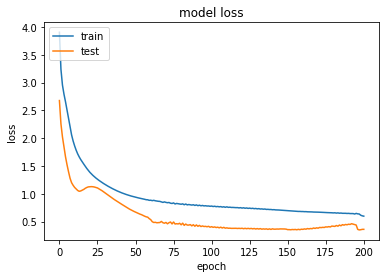

In [59]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(GRU(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Root mean squared error Train: 1.262
Root mean squared error Test: 0.376


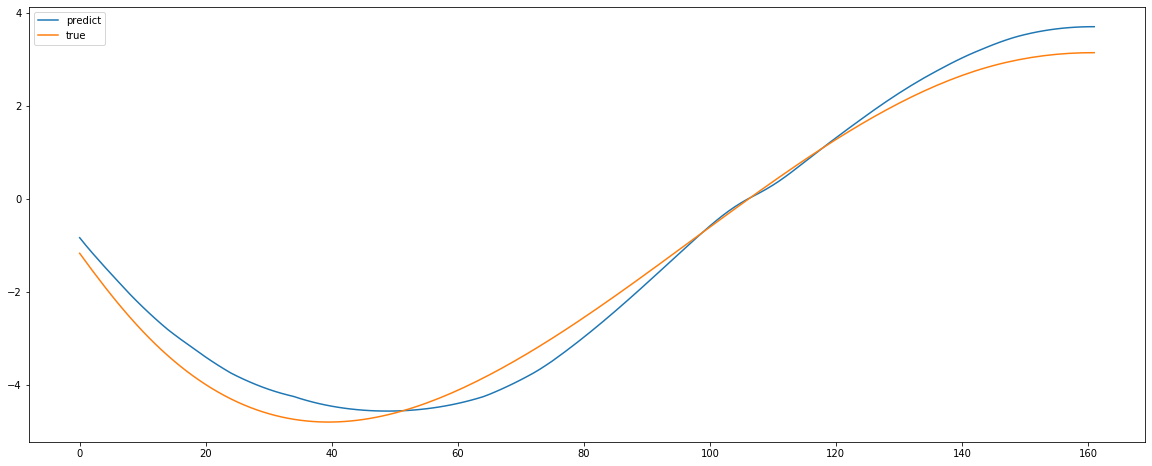

Variance : 0.982
Mean absolute error Train: 0.542
Mean absolute error Test: 0.323


In [60]:
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

In [61]:
#Simple RNN Unit

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'loss'])


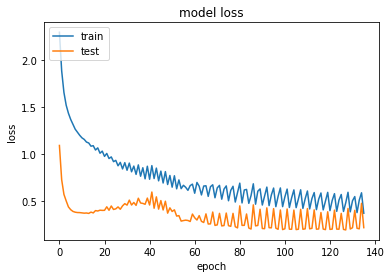

Root mean squared error Train: 0.900
Root mean squared error Test: 0.258


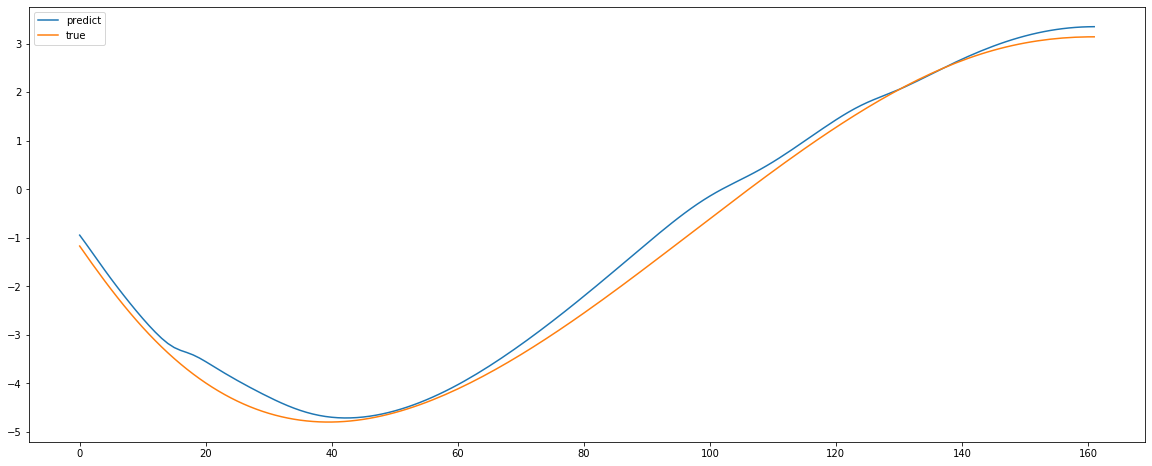

Variance : 0.991
Mean absolute error Train: 0.514
Mean absolute error Test: 0.213


In [62]:
model = Sequential()
model.add(SimpleRNN(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


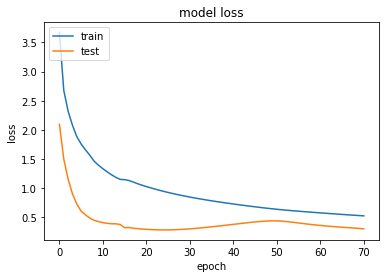

Root mean squared error Train: 0.855
Root mean squared error Test: 0.319


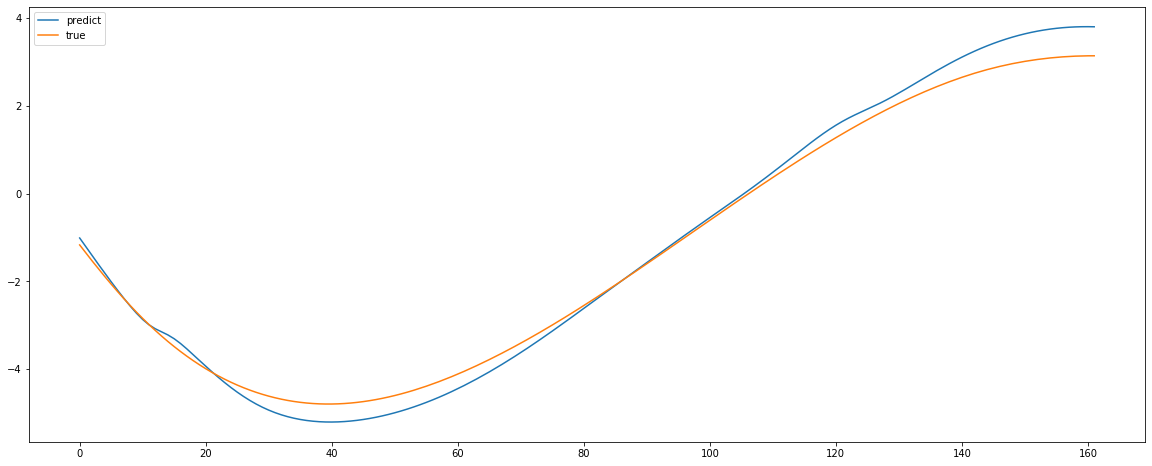

Variance : 0.987
Mean absolute error Train: 0.461
Mean absolute error Test: 0.258


In [21]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = Sequential()
model.add(SimpleRNN(look_back, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False,callbacks=[EarlyStopping(monitor='val_loss',patience=50, min_delta=0.01)])
print(model.summary())
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
yhat_train = model.predict(trainX)
print("Root mean squared error Train: %.3f" % sqrt(mean_squared_error(trainY, yhat_train)))
yhat = model.predict(testX)
print("Root mean squared error Test: %.3f" % sqrt(mean_squared_error(testY, yhat)))
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='predict')
pyplot.plot(testY[:500], label='true')
pyplot.legend()
pyplot.show()
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error Train: %.3f" % mean_absolute_error(trainY, yhat_train))
print("Mean absolute error Test: %.3f" % mean_absolute_error(testY, yhat))